# Wave equation in spacetime with Dirichlet conditions.
## Test problem is chosen to give an exact solution at all nodes of the mesh.

## Governing Equation:

$\frac{\partial^2 u}{\partial t}-c^2\Delta u = 0$

let c = 1

## Domain:

$([0,1] \times [0,1]) \times ([0,T]) $

## Exact solution:

$u_{exact} = sin(x-ct) + sin(y-ct)$

## Boundary condition:

$u = u_{exact} $ on the boundary


## Note:

For convergence results, all boundary is dirichlet. However for more pracitcal time space solution, you can switch bc2 to time_boundary and uncomment stiffness_form21


In [1]:
#Import modules
from __future__ import print_function
import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Can not Run Poisson Problem Standard way (no Cartesian Product)


#  but can now using Cartesian Product

## Domain is product of 2 square meshes


In [2]:
#Some auxillary functions defined first
def cartesian_product(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n=array1.shape
    dim2,n=array2.shape
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr
def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr
def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr


def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

In [3]:
#cartesian product of 2 1-d domains with dirichlet boundary
num_elem= 6
num_t = 12
mesh1 = dl.UnitSquareMesh(num_elem,num_elem)
mesh2 = dl.UnitIntervalMesh(num_t)
#wave speed
c1=1.333

#create function spaces for each piece
V1 = dl.FunctionSpace(mesh1, 'P', 1)
V2 = dl.FunctionSpace(mesh2, 'P', 1)

#create trial and test functions
u1_trial = dl.TrialFunction(V1)
v1_test = dl.TestFunction(V1)
u2_trial = dl.TrialFunction(V2)
v2_test = dl.TestFunction(V2)

#assemble weak forms (more complex due to chain rule)
stiffness_form11 = dl.inner(dl.grad(u1_trial), dl.grad(v1_test)) * dl.dx
stiffness_form12 = u1_trial*v1_test* dl.dx

stiffness_form21 = dl.inner(dl.grad(u2_trial), dl.grad(v2_test)) * dl.dx #- u2_trial.dx(0)*v2_test*dl.ds
stiffness_form22 = u2_trial*v2_test * dl.dx

#assign right hand side (will need to generalize later)
#f = dl.Constant(-20.0)


#assemble stiffness matrices (only will work for linear forms)
K11 = dl.assemble(stiffness_form11)
K12 = dl.assemble(stiffness_form12)
K21 = dl.assemble(stiffness_form21) 
K22 = dl.assemble(stiffness_form22)

#assign right hand sides  (no forcing so its 0)
b1 = dl.Function(V1)
b2 = dl.Function(V2)
#rhs_form1 = f*v1_test*dl.dx
#rhs_form2 = v2_test*dl.dx
#b1 = dl.assemble(rhs_form1)
#b2 = dl.assemble(rhs_form2)

#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary

def time_boundary(x, on_boundary):
    if on_boundary and np.abs(x - 0.0) < 1e-8:
        return True
    else:
        return False

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = dl.Expression('1.0', degree=2)


#establish dummy functions
dum1=dl.Function(V1)
dum2=dl.Function(V2)


#create boundary conditions
bc1 = dl.DirichletBC(V1, u_D1, boundary)
bc2 = dl.DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
bc2.apply(dum2.vector())

#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]

#print indeces of boundaries in subdomains
print(boundary_dofs1)
print(boundary_dofs2)

#need all physical coordinates in case we need for calculations
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]


#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))


ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1
    
last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
    cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    
    last_ind = last_ind+len(dof_coordinates1)    


#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)



#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)



#assemble global system using kronecker product
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())



#should sign be flipped on second term?
A= - np.kron(K12,K21) + (c1**2)*np.kron(K11,K22)




b1 = b1.vector()[:]
b2 = b2.vector()[:]
B=np.kron(b1,b2)


#need to apply bcs using boundary_dofs info
#set the rows in the boundary to 1 on diagonal
K_bound = np.zeros(A.shape)


for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]


#set the value of solution on boundary as rhs
B[global_boundary_dofs] =  np.sin(global_dof[global_boundary_dofs,0]-c1*global_dof[global_boundary_dofs,2]) + \
np.sin(global_dof[global_boundary_dofs,1]-c1*global_dof[global_boundary_dofs,2])


#solve global system
u=np.zeros(len(B))

#solve(A,u,B)
u=np.linalg.solve(A,B)



[ 0  1  2  3  5  6  9 10 14 15 20 21 27 28 33 34 38 39 42 43 45 46 47 48]
[ 0 12]


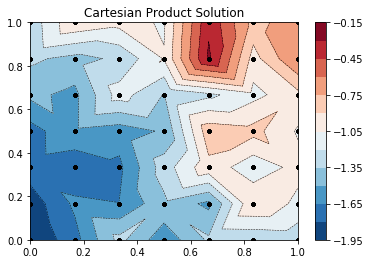

In [4]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()

#print(u)

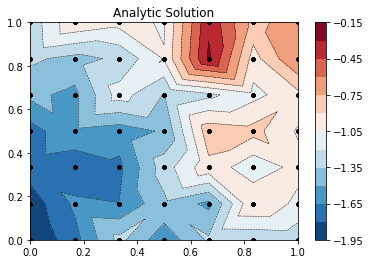

In [5]:
#plot analytic solution
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

u_true = np.sin(global_dof[:,0]-c1*global_dof[:,2]) + np.sin(global_dof[:,1]-c1*global_dof[:,2])

ax2.tricontour(global_dof[:,0], global_dof[:,1], u_true, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_true, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Analytic Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()
#print(u_true)


In [6]:
print('dof')
print(len(u))
print('h')
print(1/num_elem)
print('dt')
print(1/num_t)
print('cfl')
print(c1*num_elem/num_t)
print('l infinity')
print(max(np.absolute(u-u_true)))
print('l2')
print(np.dot(np.absolute(u-u_true),np.absolute(u-u_true)))
print('sum of absolute error')
print(np.sum(np.absolute(u-u_true)))

dof
637
h
0.16666666666666666
dt
0.08333333333333333
cfl
0.6665
l infinity
0.00113415948199
l2
6.47071615966e-05
sum of absolute error
0.113769852815


In [36]:
#print(u[global_boundary_dofs] - u_true[global_boundary_dofs])

(20, 30)


0.8513409974325955